# 背景知识

## 解决的问题

本项目使用PINN求解了2D稳态热传导方程，基本方程为：

$$
\frac{\partial^2T}{\partial x^2} + \frac{\partial^2T}{\partial y^2}=0
$$

计算域为：

$$
D = \{(x, y)|-1\leq{x}\leq{+1},-1\leq{y}\leq{+1}\}
$$

边界条件为：

$$
T(-1, y) = 75.0 ^\circ{C} \\
T(+1, y) = 0.0 ^\circ{C} \\
T(x, -1) = 50.0 ^\circ{C} \\
T(x, +1) = 0.0 ^\circ{C}
$$

## 解决的方法

解决方法参考了[Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations, p3-p5](https://arxiv.org/abs/1711.10561)。

数据驱动法求解2维偏微分方程的解的一般形式为：

$$
u(x,y) + \mathcal{N}[u] = 0 \tag{1}
$$

由式（1）定义$f(x，y)$为：

$$
f := u(x,y) + \mathcal{N}[u] \tag{2}
$$

$u(x，y)$可通过深度神经网络进行近似求解。这个假设与方程（2）一起得出了基于物理信息的神经网络$f(x，y)$。这个网络可以通过对组成函数应用链式规则进行自动微分而导出。

对于2D稳态热传导方程，可以定义$f(x，y)$为：

$$
f := u_{xx} + u_{yy}  \tag{3}
$$

然后通过深度神经网络对$u(x，y)$进行近似。采用Paddle API的$u(x，y)$定义如下：

```python
def u(self, x, y):
  u = self.layers(paddle.concat([x, y], axis=1))
  return u
```

其中`self.layers`即对$u(x，y)$的神经网络近似，网络结构为MLP。

```python
self.layers = nn.Sequential(
            Input(shape=(in_shape,), dtype=paddle.float64),
            nn.Linear(in_features=in_shape, out_features=neuron_per_layer), 
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=out_shape)
        )
```

相应地，基于物理信息的神经网络$f(x，y)$定义如下：

```python
def f(self, x, y):
  # Gradients need to be calculated
  x.stop_gradient = False
  y.stop_gradient = False

  u0 = self.u(x, y)
  u_x = paddle.grad(u0, x, retain_graph=True, create_graph=True)[0]
  u_y = paddle.grad(u0, y, retain_graph=True, create_graph=True)[0]
  u_xx = paddle.grad(u_x, x, retain_graph=True, create_graph=True)[0]
  u_yy = paddle.grad(u_y, y, retain_graph=True, create_graph=True)[0]
  
  F = u_xx + u_yy
  return F
```
神经网络$u(x，y)$和$f(x，y)$之间的共享参数可以通过最小化均方差损失来学习：

$$
MSE=MSE_u+MSE_f \tag{4}
$$

其中：

$$
MSE_u = \frac{1}{N_u}\sum_{i=1}^{N_u}{|u(x^i,y^i) - u^i|^2}
$$

$$
MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}{|f(x^i,y^i)|^2}
$$

计算MSE的参考代码如下：

```python
def forward(self, dataset):
        self.preprocess_data(dataset)
        T_ = self.u(self.x_d, self.y_d)
        L  = paddle.mean(paddle.square(self.f(self.x_c, self.y_c)))
        l  = self.mse(self.t_d, T_)
        loss = l+L
        return loss
```

# 完整代码

In [1]:
# 导入依赖
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc
import paddle
from paddle import nn

print(paddle.__version__)
#paddle.utils.run_check()
paddle.set_default_dtype("float64")

# For the use of the second derivative: paddle.cos, paddle.exp, see [4]
paddle.framework.core.set_prim_eager_enabled(True)

2.5.1


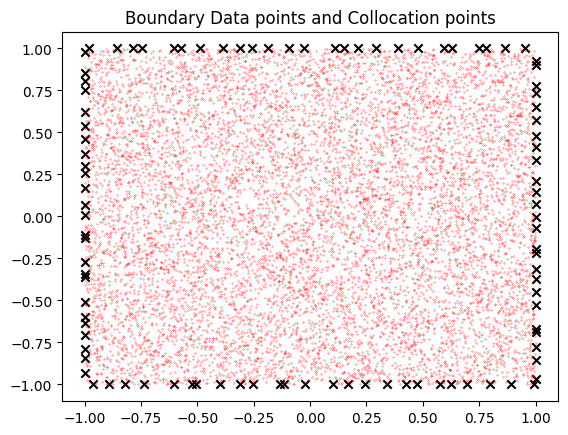

In [2]:
### 生成数据
n_bc = 4
n_data_per_bc = 25

#
engine = qmc.LatinHypercube(d=1)
data = np.zeros([4, 25, 3])

for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
    if i < 2:
        data[i, :, 0] = j
        data[i, :, 1] = points
    else:
        data[i, :, 0] = points
        data[i, :, 1] = j

# BC Values
# normalized in [0, 1]
data[0, :, 2] = 1.
data[2, :, 2] = 50/75

data = data.reshape(n_data_per_bc * n_bc, 3)
#
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])

#

Nc = 10000
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 2 * (colloc -0.5)
#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

#

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="r", label="CP")
plt.show()

#

x_c, y_c, x_d, y_d, t_d =map(lambda x: paddle.to_tensor(x,dtype=paddle.float64), [x_c, y_c, x_d, y_d, t_d])
#x_c, y_c, x_d, y_d, t_d =map(lambda x: paddle.to_tensor(x,dtype=paddle.float32), [x_c, y_c, x_d, y_d, t_d])

In [3]:
# 定义模型
from paddle.nn import Layer
from paddle import Tensor

class Input(Layer):
    def __init__(self, shape : tuple, device=paddle.device.get_device(), dtype=paddle.float32):
        
        super().__init__()

        self.shape = shape
        self.device = device
        self.dtype = dtype

    def forward(self, x):
        tensor_shape = tuple(x.shape[1:])

        #if x.device != self.device:
        #    raise ValueError(f"Input tensor must be on device {self.device} but got device {x.device} instead")
        if x.dtype != self.dtype:
            raise ValueError(f"Input tensor must have data type {self.dtype} but got data type {x.dtype} instead")
        if tensor_shape != self.shape:
            raise ValueError(f"Input shape must be {self.shape} but got {tensor_shape} instead")
        
        #return (x.to(self.device, self.dtype))
        return paddle.clone(x)

### 创建模型   
class TestModel(Layer):
    def __init__(self, in_shape=2, out_shape=1, n_hidden_layers=10, neuron_per_layer=20, actfn="tanh"):
        super().__init__()
        # input layer
        #self.input_layer = Input(shape=(in_shape,))
        # hidden layers
        #self.hidden = [nn.Linear(in_features=in_shape, out_features=neuron_per_layer), nn.Tanh()]
        #for i in range(n_hidden_layers-1):
        #    new_layer = nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer)
        #    act_layer = nn.Tanh()
        #    self.hidden.append(new_layer)
        #    self.hidden.append(act_layer)
        # output layer
        #self.output_layer = nn.Linear(in_features=neuron_per_layer, out_features=out_shape)

        self.layers = nn.Sequential(
            Input(shape=(in_shape,), dtype=paddle.float64),
            nn.Linear(in_features=in_shape, out_features=neuron_per_layer), 
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=neuron_per_layer),
            nn.Tanh(),
            nn.Linear(in_features=neuron_per_layer, out_features=out_shape)
        )

    def u(self, x, y):
        #x = self.input_layer(paddle.concat([x, y], axis=1))
        #for hl in self.hidden:
        #    x = hl(x)
        #u = self.output_layer(x)
        u = self.layers(paddle.concat([x, y], axis=1))
        return u

    def f(self, x, y):
        # Gradients need to be calculated
        x.stop_gradient = False
        y.stop_gradient = False

        u0 = self.u(x, y)
        u_x = paddle.grad(u0, x, retain_graph=True, create_graph=True)[0]
        u_y = paddle.grad(u0, y, retain_graph=True, create_graph=True)[0]
        u_xx = paddle.grad(u_x, x, retain_graph=True, create_graph=True)[0]
        u_yy = paddle.grad(u_y, y, retain_graph=True, create_graph=True)[0]
        F = u_xx + u_yy
        #return paddle.mean(paddle.square(F))
        return F
    
    def mse(self, y, y_):
        return paddle.mean(paddle.square(y-y_))

    def preprocess_data(self, dataset):
        x_c, y_c, x_d, y_d, t_d = dataset
        self.x_c = paddle.to_tensor(x_c, dtype=paddle.float64)
        self.y_c = paddle.to_tensor(y_c, dtype=paddle.float64)
        self.x_d = paddle.to_tensor(x_d, dtype=paddle.float64)
        self.y_d = paddle.to_tensor(y_d, dtype=paddle.float64)
        self.t_d = paddle.to_tensor(t_d, dtype=paddle.float64)

    def forward(self, dataset):
        self.preprocess_data(dataset)
        T_ = self.u(self.x_d, self.y_d)
        L  = paddle.mean(paddle.square(self.f(self.x_c, self.y_c)))
        l  = self.mse(self.t_d, T_)
        loss = l+L
        return loss
        #return T_

In [4]:
# 创建模型
model = TestModel(2, 1, 9, 20, "tanh")
dataset = ( x_c, y_c, x_d, y_d, t_d )

W1009 10:14:56.764891 26009 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 11.7, Runtime API Version: 11.7
W1009 10:14:56.766639 26009 gpu_resources.cc:149] device: 0, cuDNN Version: 8.9.


In [5]:
#params_info = paddle.summary(model, input=dataset)
#print(params_info)

    0, Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=False,
       0.57877364)
  100, Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=False,
       0.04775335)
  200, Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=False,
       0.04389104)
  300, Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=False,
       0.04059296)
  400, Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=False,
       0.03406762)
  500, Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=False,
       0.02631616)
  600, Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=False,
       0.02370327)
  700, Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=False,
       0.02280367)
  800, Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=False,
       0.02020391)
  900, Tensor(shape=[], dtype=float64, place=Place(gpu:0), stop_gradient=False,
       0.01921216)
  999, Ten

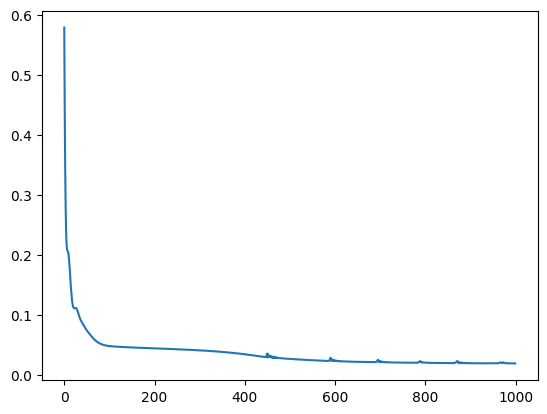

In [6]:
# 训练
loss = 0
epochs = 1000
opt = paddle.optimizer.Adam(learning_rate=5e-4, parameters=model.parameters())
epoch = 0
loss_values = np.array([])
#
start = time.time()
#
for epoch in range(epochs):
    # forward pass and loss calculation 
    # implicit tape-based AD 
    loss = model(dataset)
   
    # compute gradients (grad)
    loss.backward()
    # update training variables / parameters
    opt.step()
    opt.clear_grad()

    loss_values = np.append(loss_values, loss)
    if epoch % 100 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss}")

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
#plt.semilogy(loss_values)
#plt.legend()
plt.plot(loss_values)

In [7]:
# 实现FDM
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])

bc = {
    "x=-l": 75.,
    "x=+l": 0.,
    "y=-l": 50.,
    "y=+l": 0.
}

In [8]:
B = np.zeros([n, n])
k = 0
for i in range(n):
    x = i * r
    for j in range(n):
        y = j * r
        M = np.zeros([n, n])
        M[i, j] = -4
        if i != 0: # ok i know
            M[i-1, j] = 1
        else:
            B[i, j] += -bc["y=-l"]   # b.c y = 0
        if i != n-1:
            M[i+1, j] = 1
        else:
            B[i, j] += -bc["y=+l"]   # b.c y = l
        if j != 0:
            M[i, j-1] = 1
        else:
            B[i, j] += -bc["x=-l"]   # b.c x = 0
        if j != n-1:
            M[i, j+1] = 1
        else:
            B[i, j] += -bc["x=+l"]   # b.c x = l
        #B[i, j] += -r**2 * q(x, y) * K(x, y)
        m = np.reshape(M, (1, n**2))
        T[k, :] = m
        k += 1

#
b = np.reshape(B, (n**2, 1))
start = time.time()
T = np.matmul(np.linalg.inv(T), b)
T = T.reshape([n, n])
Temperature = T
end = time.time()
computation_time["fdm"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")


computation time: 8.114



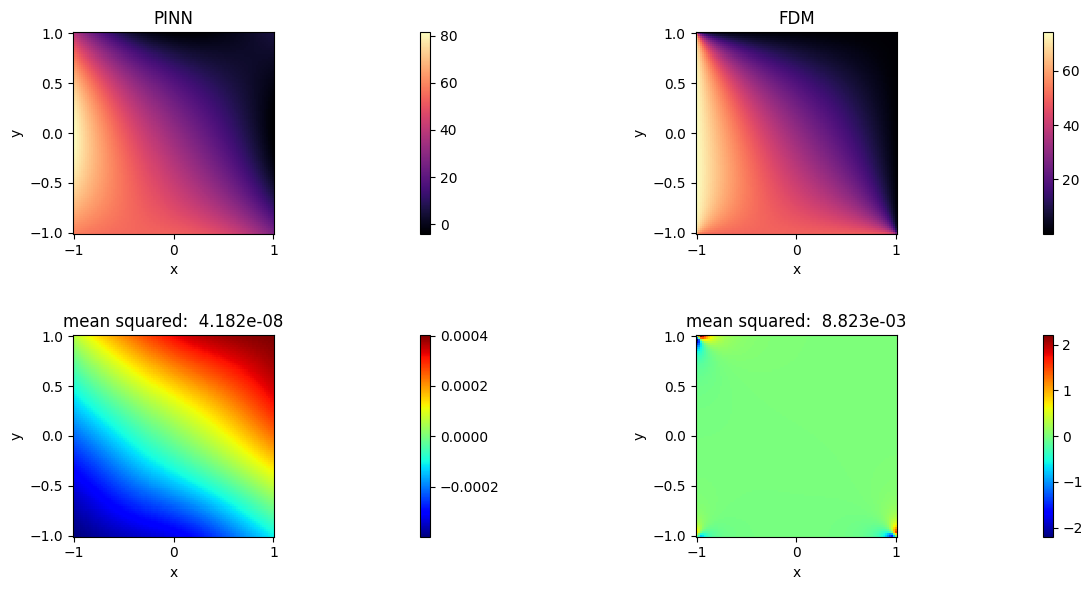

In [9]:
### 绘图
plt.figure("", figsize=(12, 6))
#
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = paddle.to_tensor(X)
Y_T = paddle.to_tensor(Y)
# 用PINN计算
S = model.u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 75.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN")
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)
#
plt.subplot(222)
plt.pcolormesh(x, y, T, cmap="magma")
plt.colorbar()
plt.title(r"FDM")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
plt.savefig("heat01.png")
#
plt.subplot(223)
pinn_grad = np.gradient(np.gradient(S, axis=0), axis=1)
sigma_pinn = (pinn_grad**2).mean()
plt.pcolormesh(X0, Y0, pinn_grad, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"" + f"\nmean squared: {sigma_pinn: .3e}")
plt.tight_layout()
plt.axis("square")
###
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)
#
plt.subplot(224)
fdm_grad = np.gradient(np.gradient(T, axis=0), axis=1)
sigma_fdm = (fdm_grad**2).mean()
plt.pcolormesh(x, y, fdm_grad, cmap="jet")
plt.colorbar()
plt.title(r"" + f"\nmean squared: {sigma_fdm: .3e}")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
plt.savefig("heat01.png")
plt.show()

In [10]:
print("performance comparison".center(26))
print("="*26)
for method in computation_time:
    print(f"{method}\t\t{computation_time[method]:6.2f} (s)")

  performance comparison  
pinn		 65.93 (s)
fdm		  8.11 (s)


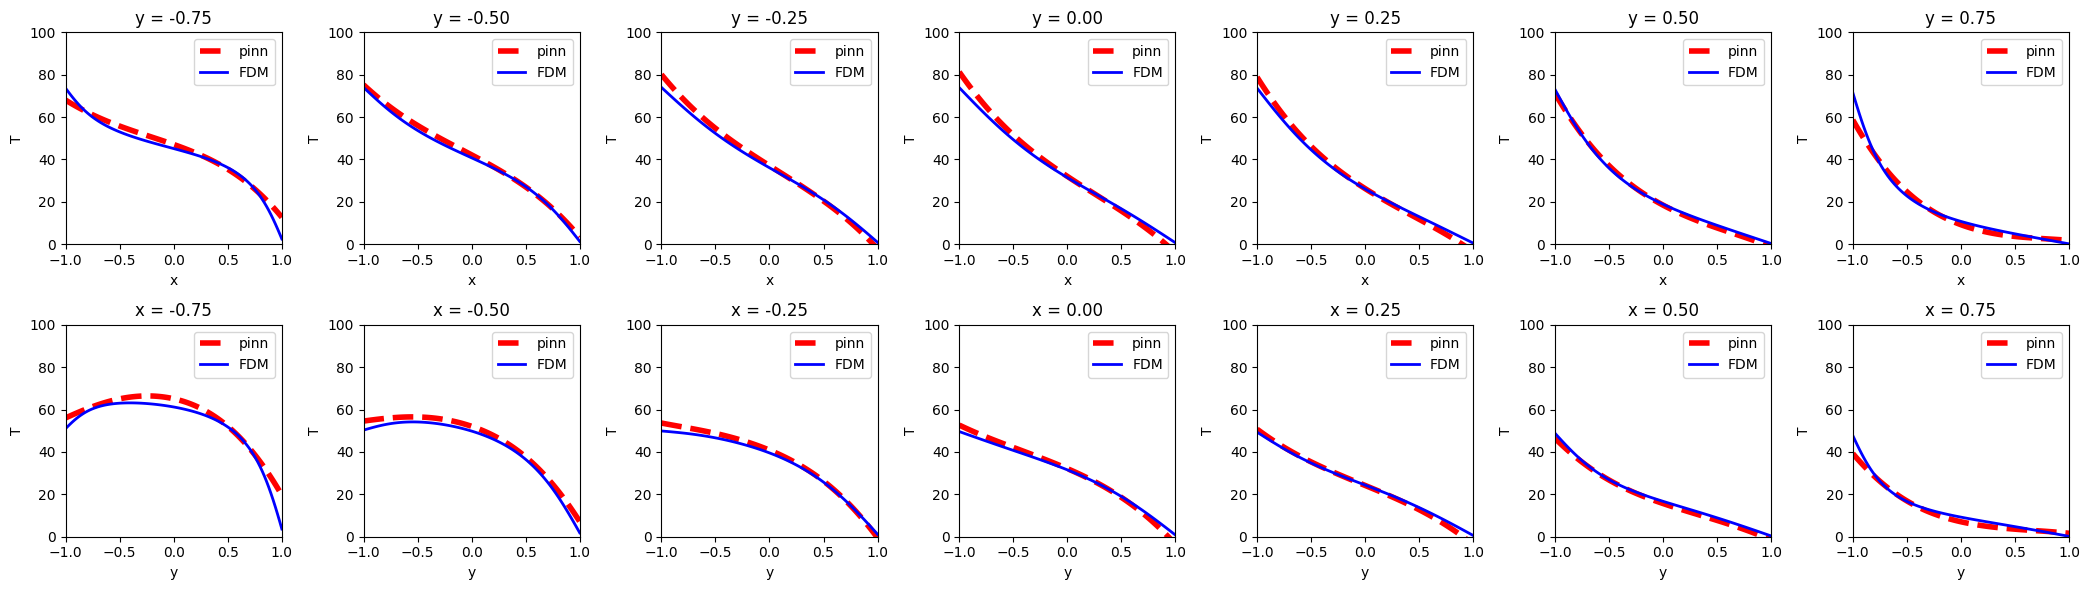

In [11]:
S_ = S.reshape([n, n])
T_ = T.reshape([n, n])

height = 3
frames_val = np.array([-.75, -.5, -.25, 0., +.25, +.5, +.75])
frames = [*map(int, (frames_val + 1)/2 * (n-1))]
fig = plt.figure("", figsize=(len(frames)*height, 2*height))

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title(f"y = {frames_val[i]:.2f}")
    plt.plot(X0[var_index, :], 75.*S_[var_index,:], "r--", lw=4., label="pinn")
    plt.plot(X0[var_index, :], T_[var_index,:], "b", lw=2., label="FDM")
    plt.ylim(0., 100.)
    plt.xlim(-1., +1.)
    plt.xlabel("x")
    plt.ylabel("T")
    plt.tight_layout()
    plt.legend()

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), len(frames) + i+1)
    plt.title(f"x = {frames_val[i]:.2f}")
    plt.plot(Y0[:, var_index], 75.*S_[:,var_index], "r--", lw=4., label="pinn")
    plt.plot(Y0[:, var_index], T_[:,var_index], "b", lw=2., label="FDM")
    plt.ylim(0., 100.)
    plt.xlim(-1., +1.)
    plt.xlabel("y")
    plt.ylabel("T")
    plt.tight_layout()
    plt.legend()

plt.savefig("profiles.png")
plt.show()

In [12]:
# 保存模型
obj = {'model': model.state_dict(), 'opt': opt.state_dict(), 'epoch': 1000}
path = 'model.pdparams'
paddle.save(obj, path)

# 参考资料

- [参考项目：Heat-PINN](https://github.com/314arhaam/heat-pinn/tree/main) 
- [PaddleScience案例：2D-Laplace](https://github.com/PaddlePaddle/PaddleScience/blob/develop/examples/laplace/laplace2d.py) 
- [XPINN_2D_PoissonsEqn](https://github.com/PaddlePaddle/PaddleScience/blob/develop/jointContribution/XPINNs/XPINN_2D_PoissonsEqn.py)
- [PaddleScience复现指南](https://paddlescience-docs.readthedocs.io/zh/latest/zh/reproduction/#2)
- [Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations, p3-p5](https://arxiv.org/abs/1711.10561)
- [Tensorflow和PyTorch 对应API速查表](https://zhuanlan.zhihu.com/p/471543752)
- [4.3. 多层感知机的简洁实现](http://zh.d2l.ai/chapter_multilayer-perceptrons/mlp-concise.html)
- [Whats the equivalent of tf.keras.Input() in pytorch?](https://stackoverflow.com/questions/64780641/whats-the-equivalent-of-tf-keras-input-in-pytorch)
- [What is tape-based autograd in Pytorch?](https://stackoverflow.com/questions/64856195/what-is-tape-based-autograd-in-pytorch)

